### データとしては4つ用意。
・all_data : strain, orien, aspect, size, boundary, structure, subtractionの6つ全てを離散化なし<br>
・all_data_qcut : すべてのcolumnsを含んで全て離散化<br>
・df : 4つのcolumnsを離散化なしで<br>
・df_qcut : 4つのcolumnsを離散化<br>

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [59]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

In [60]:
all_data = pd.read_csv('./csv_files/all_data.csv')
all_data = all_data[~all_data[['strain', 'orien']].isnull().any(axis=1)].reset_index(drop=True)

In [61]:
print(all_data.shape)
all_data.head()

(168, 8)


,id,boundary,structure,strain,orien,aspect,size,subtraction
0,2,0,2,1.0,4.0,0.589215,203.32,117.53
1,3,0,0,2.0,4.0,0.290944,15.91,13.29
2,4,0,0,3.0,1.0,0.256198,257.93,202.06
3,5,0,0,2.0,4.0,0.120000,84.60,52.88
4,6,0,0,2.0,2.0,0.340909,21.04,18.55


In [62]:
all_data['sub'] = all_data['size'] - all_data['subtraction']

*6つの特徴量　離散化なし*

In [381]:
y_train = all_data.subtraction.values
train = all_data.drop(['id', 'subtraction'], axis=1).values
train = scipy.stats.zscore(train)

*6つの特徴量　離散化あり*

In [254]:
all_data.size = pd.qcut(all_data['size'], 5, labels=False)
all_data.aspect = pd.qcut(all_data['aspect'], 5, labels=False)
all_data[['strain', 'orien']] = all_data[['strain', 'orien']].astype('int64')
y_train = all_data.subtraction.values
train = all_data.drop(['id', 'subtraction'], axis=1).values
train = scipy.stats.zscore(train)

*4つの特徴量　離散化なし*

In [5]:
all_data = all_data.iloc[:, 3:]
y_train = all_data.subtraction.values
train = all_data.drop(['subtraction'], axis=1).values
train = scipy.stats.zscore(train)

*4つの特徴量　ターゲットを12%変形後の面積に　離散化なし*

In [44]:
y_train = all_data['sub'].values
train = all_data.drop(['id', 'boundary', 'structure', 'subtraction', 'sub'], axis=1).values
train = scipy.stats.zscore(train)

*4つの特徴量　離散化あり*

In [297]:
all_data.size = pd.qcut(all_data['size'], 5, labels=False)
all_data.aspect = pd.qcut(all_data['aspect'], 5, labels=False)
all_data[['strain', 'orien']] = all_data[['strain', 'orien']].astype('int64')
all_data = all_data.iloc[:, 3:]
y_train = all_data.subtraction.values
train = all_data.drop(['subtraction'], axis=1).values
train = scipy.stats.zscore(train)

*4つの特徴量　体積減少率　離散化なし*

In [361]:
temp = pd.read_csv('./csv_files/input_DecreaseRate.csv')
temp = temp.rename(columns={'Strain':'strain', 'Orien':'orien',
                            'Aspect':'aspect', 'Size':'size', 'Decrease':'subtraction'})
all_data = temp.copy()
y_train = all_data.subtraction.values
train = all_data.drop(['subtraction'], axis=1).values
train = scipy.stats.zscore(train)

*size < 8.41の（68インスタンス）で6つの特徴量　離散化なし*

In [421]:
all_data = all_data[all_data['size'] < 8.411]
y_train = all_data.subtraction.values
train = all_data.drop(['id', 'subtraction'], axis=1).values
train = scipy.stats.zscore(train)

In [46]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(
    train, y_train, test_size=0.1, random_state=42
)

## cross-validation開始

In [47]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
n_folds = 10

def rmsle_cv(model):
    kf = StratifiedKFold(n_folds, shuffle=True, random_state=42).get_n_splits(xtrain)
    rmse= np.sqrt(-cross_val_score(model, xtrain, ytrain, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

## 様々な予測器を試す。

In [48]:
from sklearn.kernel_ridge import KernelRidge
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [49]:
import xgboost as xgb
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [50]:
import lightgbm as lgb
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [51]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(random_state=42)

In [52]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()

## それぞれの予測器のrmseをみる

In [389]:
print('all_data : 6つの特徴量　離散化なし')
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(lin_reg)
print("\nlin_reg score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(forest_reg)
print("\nforest_reg score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

all_data : 6つの特徴量　離散化なし
Kernel Ridge score: 7.4659 (3.5065)

Xgboost score: 11.9080 (6.4645)

LGBM score: 14.5790 (6.2251)


lin_reg score: 7.7639 (2.6642)


forest_reg score: 10.8793 (5.5807)



In [263]:
print('all_data : 6つの特徴量　離散化あり')
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})".format(score.mean(), score.std()))
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})".format(score.mean(), score.std()))
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})".format(score.mean(), score.std()))
score = rmsle_cv(lin_reg)
print("\nlin_reg score: {:.4f} ({:.4f})".format(score.mean(), score.std()))
score = rmsle_cv(forest_reg)
print("\nforest_reg score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

all_data_qcut : 6つの特徴量　離散化あり
Kernel Ridge score: 21.8192 (10.3601)

Xgboost score: 24.2520 (7.1271)

LGBM score: 18.4949 (8.5521)


lin_reg score: 20.7278 (10.7407)


forest_reg score: 18.7822 (8.0277)



In [324]:
print('all_data : 4つの特徴量　離散化なし')
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})".format(score.mean(), score.std()))
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})".format(score.mean(), score.std()))
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})".format(score.mean(), score.std()))
score = rmsle_cv(lin_reg)
print("\nlin_reg score: {:.4f} ({:.4f})".format(score.mean(), score.std()))
score = rmsle_cv(forest_reg)
print("\nforest_reg score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

all_data : 4つの特徴量　離散化なし
Kernel Ridge score: 6.4862 (2.6036)
Xgboost score: 12.5488 (6.5933)
LGBM score: 14.5882 (6.1702)

lin_reg score: 7.5214 (2.5696)

forest_reg score: 10.4795 (5.6747)


In [53]:
print('all_data : 4つの特徴量　12%サイズをターゲットに　離散化なし')
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})".format(score.mean(), score.std()))
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})".format(score.mean(), score.std()))
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})".format(score.mean(), score.std()))
score = rmsle_cv(lin_reg)
print("\nlin_reg score: {:.4f} ({:.4f})".format(score.mean(), score.std()))
score = rmsle_cv(forest_reg)
print("\nforest_reg score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

all_data : 4つの特徴量　離散化なし
Kernel Ridge score: 6.4297 (2.5345)
Xgboost score: 10.8906 (4.3852)
LGBM score: 9.3685 (3.8509)

lin_reg score: 7.5214 (2.5696)

forest_reg score: 8.6535 (4.3183)


In [306]:
print('all_data : 4つの特徴量　離散化あり')
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})".format(score.mean(), score.std()))
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})".format(score.mean(), score.std()))
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})".format(score.mean(), score.std()))
score = rmsle_cv(lin_reg)
print("\nlin_reg score: {:.4f} ({:.4f})".format(score.mean(), score.std()))
score = rmsle_cv(forest_reg)
print("\nforest_reg score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

all_data : 4つの特徴量　離散化あり
Kernel Ridge score: 18.0110 (9.1003)

Xgboost score: 17.6561 (8.8187)

LGBM score: 17.7170 (8.6502)


lin_reg score: 20.1769 (10.1799)


forest_reg score: 18.3700 (8.2380)



In [369]:
print('all_data : 4つの特徴量　体積減少率　離散化なし')
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(lin_reg)
print("\nlin_reg score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(forest_reg)
print("\nforest_reg score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

all_data : 4つの特徴量　体積減少率　離散化なし
Kernel Ridge score: 13.5557 (2.5681)

Xgboost score: 17.0989 (2.0803)

LGBM score: 14.1470 (2.1700)


lin_reg score: 13.4536 (2.4215)


forest_reg score: 14.4945 (2.3936)



In [429]:
print('all_data : 6つの特徴量　size < 8.41　離散化なし')
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(lin_reg)
print("\nlin_reg score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(forest_reg)
print("\nforest_reg score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

all_data : 6つの特徴量　size < 8.41　離散化なし
Kernel Ridge score: 1.1340 (0.3206)

Xgboost score: 1.0479 (0.3787)

LGBM score: 1.2026 (0.3548)


lin_reg score: 1.0365 (0.3083)


forest_reg score: 0.9399 (0.3471)



## correlation coefficientの計算と、random forestのGridSearch開始

In [54]:
def cc(y, y_pre):
    correlation = pd.DataFrame({'y':y, 'y_pre':y_pre})
    return print('correlation coefficient is: {0:0.3f}'.format(correlation.corr().iloc[0,1]))

In [55]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
KRR.fit(xtrain, ytrain)
cc(KRR.predict(xtest), ytest)

correlation coefficient is: 0.549


In [56]:
forest_reg = RandomForestRegressor(random_state=1)
forest_reg.fit(xtrain, ytrain)
cc(forest_reg.predict(xtest), ytest)

correlation coefficient is: 0.799


In [57]:
fi = forest_reg.feature_importances_.reshape(1,-1)
fi

array([[0.06217563, 0.03567118, 0.08735195, 0.81480124]])

mean correlation:  0.7090781631430926


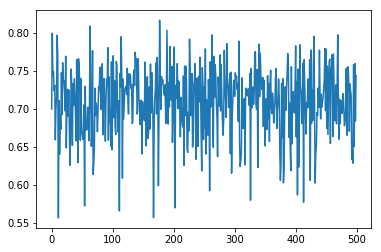

In [58]:
import matplotlib.pyplot as plt

nrange = range(0,500)
grid_score = []
feature_importances = np.ones((0,xtrain[0, :].shape[0]))

for i in nrange:
    forest_reg = RandomForestRegressor(random_state=i)
    forest_reg.fit(xtrain, ytrain)
    correlation = pd.DataFrame({'y':ytest, 'y_pre':forest_reg.predict(xtest)})
    grid_score.append(correlation.corr().iloc[0,1])
    fi = forest_reg.feature_importances_.reshape(1,-1)
    feature_importances = np.r_[feature_importances, fi]
print('mean correlation: ', np.mean(grid_score))
plt.plot(nrange, grid_score)
plt.show()

In [435]:
print('when size < 8.41 and 6 features with no recretization')
pd.DataFrame(feature_importances.mean(axis=0), index=list(all_data.columns[1:7]), columns=['feature_importances_'])

when size < 8.41 and 6 features with no recretization


,feature_importances_
boundary,0.008368
structure,0.036591
strain,0.045129
orien,0.032072
aspect,0.089174
size,0.788665


In [399]:
print('when 6 features with no recretization')
pd.DataFrame(feature_importances.mean(axis=0), index=list(all_data.columns[1:7]), columns=['feature_importances_'])

when 6 features with no recretization


,feature_importances_
boundary,0.007702
structure,0.006475
strain,0.011902
orien,0.009008
aspect,0.016138
size,0.948775


In [18]:
print('when 4 features without recretization')
pd.DataFrame(feature_importances.mean(axis=0), index=list(all_data.columns[0:4]), columns=['feature_importances_'])

when 4 features without recretization


,feature_importances_
strain,0.012899
orien,0.010522
aspect,0.018304
size,0.958275


In [354]:
ls csv_files/

all_data.csv                  representative.csv
coef_subtraction.csv          subtraction_before_dummy.csv
input_DecreaseRate.csv        subtraction_get_dummy.csv
input_microSubtraction.csv    test.csv
input_mixed.csv               test2.csv
input_mixed_over60%.csv       test_for_pp.csv
input_normalized&Sized.csv
